In [27]:
from matplotlib import pyplot as plt
from time import process_time
import recognizer
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [2]:
data = []
pred_data = []

for root, subdirs, files in os.walk('dataset/xml_logs'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                # if test data label = 10 then data else test_data append
                data.append((label, resampled))

for root, subdirs, files in os.walk('dataset/val_data'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                # if test data label = 10 then data else test_data append
                pred_data.append((label, resampled))

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [3]:
#print(test_data[0])
#print(test_data.count('left_sq_bracket'))
print(len(pred_data))
#print(data[0][0])

160


In [4]:
# Prepare the data
labels = [sample[0] for sample in data]
pred_labels = [sample[0] for sample in pred_data]

#print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
pred_labels_encoded = encoder.fit_transform(pred_labels)

#print(set(labels_encoded))

y = to_categorical(labels_encoded)
y_pred_test = to_categorical(pred_labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
pred_seq = [sample[1] for sample in pred_data]
X = np.array(sequences)
X_pred_test = np.array(pred_seq)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_pred_test.shape, X_pred_test.shape)

16
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16) (160, 16) (160, 50, 2)


In [5]:
def get_model(layers):
    # Define the model
    model = Sequential()
    
    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(layers, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

model_64 = get_model(64)
model_32 = get_model(32)
model_16 = get_model(16)
model_8 = get_model(8)

In [7]:
# Train the model
history_64 = model_64.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 9ms/step - loss: 1.5689 - accuracy: 0.5273 - val_loss: 0.5374 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 7ms/step - loss: 0.2841 - accuracy: 0.9336 - val_loss: 0.1887 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0952 - accuracy: 0.9819 - val_loss: 0.1102 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0806 - accuracy: 0.9805 - val_loss: 0.0589 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0557 - accuracy: 0.9875 - val_loss: 0.0991 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0562 - accuracy: 0.9863 - val_loss: 0.0469 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 7ms/step - lo

In [8]:
history_32 = model_32.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 7ms/step - loss: 2.0396 - accuracy: 0.4941 - val_loss: 0.9618 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 0.5007 - accuracy: 0.8887 - val_loss: 0.2692 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 5ms/step - loss: 0.2329 - accuracy: 0.9395 - val_loss: 0.1721 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 0.1612 - accuracy: 0.9563 - val_loss: 0.1341 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 5ms/step - loss: 0.0962 - accuracy: 0.9775 - val_loss: 0.1024 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 0.0813 - accuracy: 0.9795 - val_loss: 0.0740 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - lo

In [9]:
history_16 = model_16.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 6ms/step - loss: 2.3078 - accuracy: 0.3889 - val_loss: 1.7085 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 4ms/step - loss: 1.1464 - accuracy: 0.6675 - val_loss: 0.7419 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.5178 - accuracy: 0.8657 - val_loss: 0.3442 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 4ms/step - loss: 0.2592 - accuracy: 0.9468 - val_loss: 0.1931 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 4ms/step - loss: 0.1662 - accuracy: 0.9619 - val_loss: 0.1424 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 4ms/step - loss: 0.1119 - accuracy: 0.9746 - val_loss: 0.1337 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 4ms/step - lo

In [10]:
history_8 = model_8.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 6ms/step - loss: 2.5131 - accuracy: 0.2329 - val_loss: 2.1470 - val_accuracy: 0.3359 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 4ms/step - loss: 1.8053 - accuracy: 0.4585 - val_loss: 1.5082 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 1.2523 - accuracy: 0.5962 - val_loss: 1.0439 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 4ms/step - loss: 0.8856 - accuracy: 0.7100 - val_loss: 0.7659 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6524 - accuracy: 0.7944 - val_loss: 0.5570 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 4ms/step - loss: 0.4819 - accuracy: 0.8435 - val_loss: 0.4241 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 4ms/step - lo

In [11]:
model_64.summary()
model_32.summary()
model_16.summary()
model_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 19,760
Trainable params: 19,760
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4480      
                                                                 
 dense_2 (Dense)             (

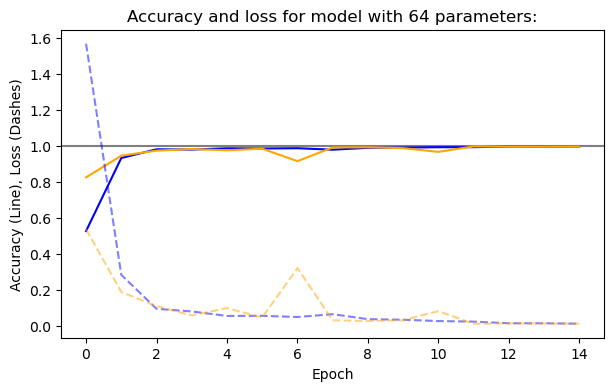

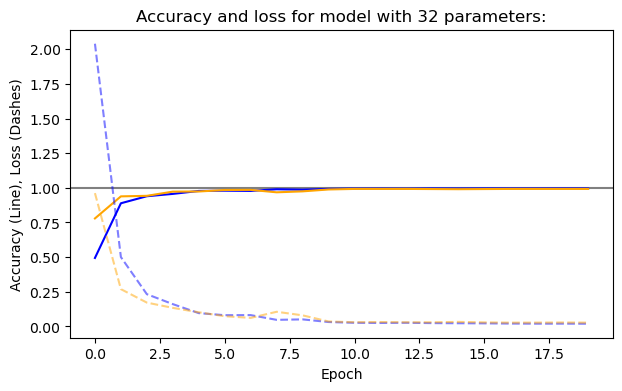

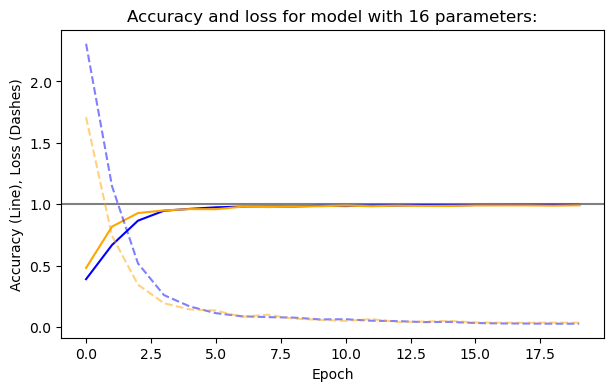

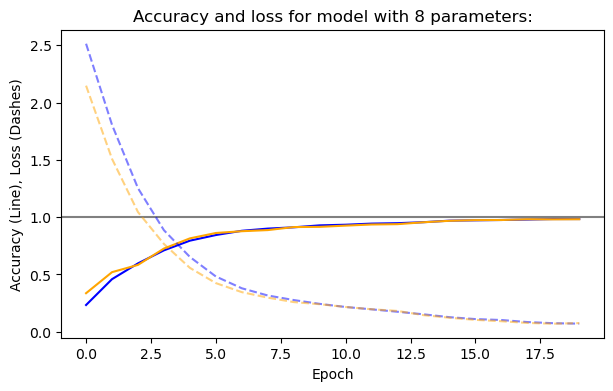

In [15]:
histories = [history_64, history_32, history_16, history_8]

params_count = 64

for history in histories:
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(7, 4))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.title(f"Accuracy and loss for model with {int(params_count)} parameters:")
    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
    
    params_count /= 2

5/5 [==============================] - 0s 4ms/step
0.03125
5/5 [==============================] - 0s 3ms/step
0.140625
5/5 [==============================] - 0s 2ms/step
0.140625
5/5 [==============================] - 0s 2ms/step
0.171875


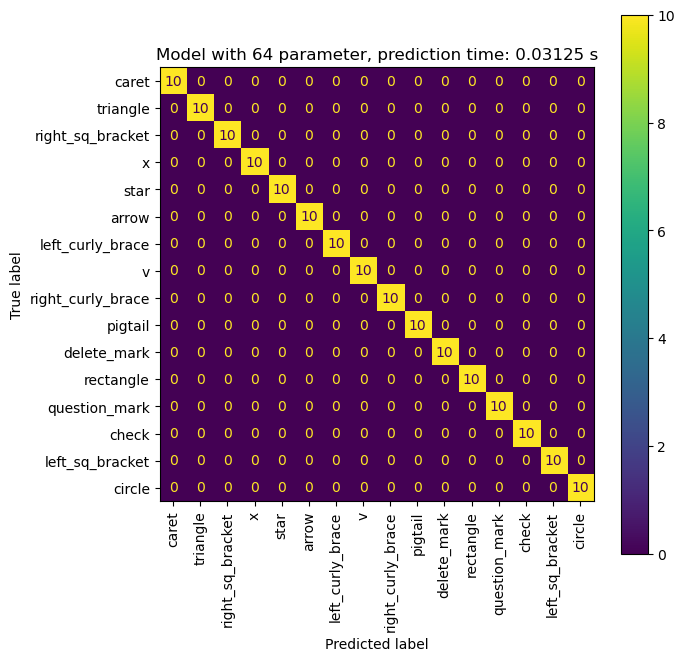

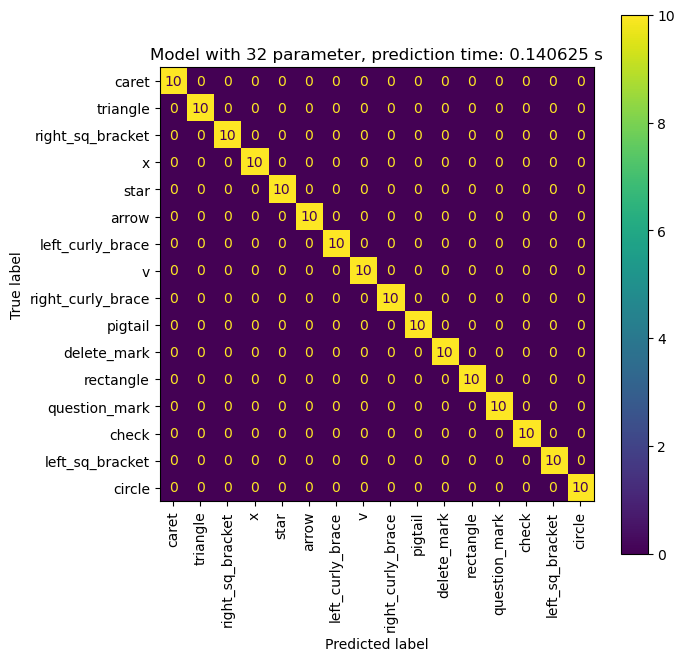

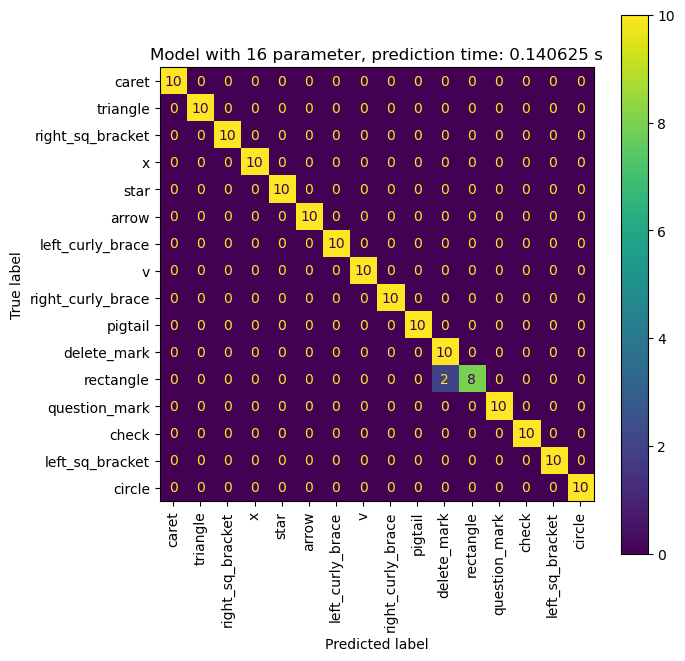

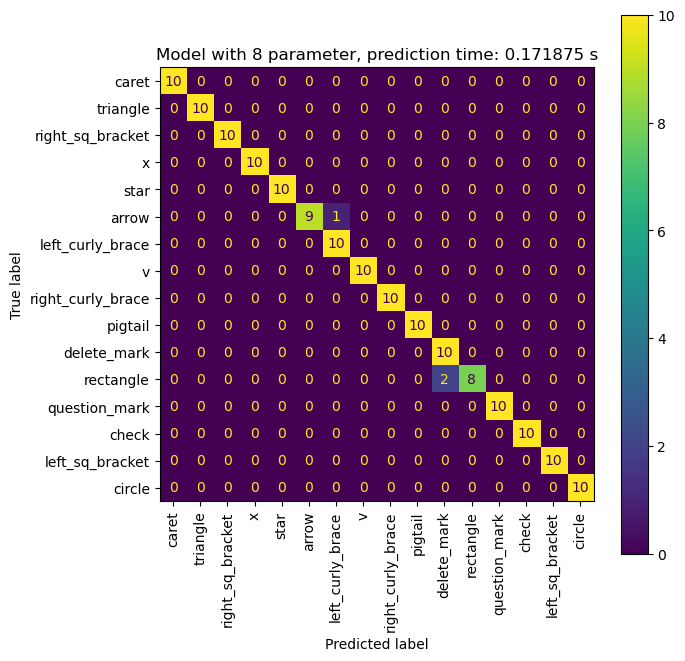

In [33]:
models = [model_64, model_32, model_16, model_8]
params_count = 64

for model in models:
    
    t0 = process_time()
    
    # let the model make predictions for our training data
    y_predictions = model.predict(X_pred_test)
    
    t1 = process_time()
    time_to_predict = t1 - t0
    
    print(time_to_predict)

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_pred_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(7, 7))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    plt.title(f'Model with {int(params_count)} parameter, prediction time: {time_to_predict} s')
    
    params_count /= 2
    pass

In [29]:
dollar_recognizer = recognizer.DollarRecognizer()




In [32]:
X_pred_test[0][0]

array([-1.98115675,  1.98053787])

# Results

| Parameter count | accuracy | val_accuracy | prediction time (160 samples) | prediciton mistakes | 
|:---:|:---:| :---:|:---:|:---:|
| 64 | 0.9978 | 0.9980 | 0.03125 s  | 0 |
| 32 | 0.9958 | 0.9922 | 0.140625 s | 0 |
| 16 | 0.9949 | 0.9912 | 0.140625 s | 2 |
| 8 | 0.9832 | 0.9814 | 0.171875 s | 3 | 

By far the fastest prediction with 0.03 seconds for the 160 samples was the LSTM with 64 layers(?), its accuracy in training was also the highest. The less parameters the model has, the less accuracy it gets in training and also the longer the prediction will take (model with 8 parameters: 0.9832 accuracy in training, 0.17 seconds prediction time). Also the less parameter the model has, the more mistakes it did with the test samples. The two models with 64 and 32 parameters didn't do any prediction mistakes, the model with 16 did 2 and the model with 8 did 3 prediction mistakes. 

## Comparision with the \$1 Recognizer

Todo